# Stack Exchange Tag Prediction


[Stack exchange](http://www.stackexchange.com) is a popular question and answer based website.  Users post and answer questions, and points are awarded for good answers based on community feedback.  There are several boards on stack exchange dedicated to specific topics such as 
* Cryptography
* Travel
* Physics 
* Math
* Cooking

The questions have a short title, and a longer content section where the user describes the question in more detail.  There are tags associated with each question to allow users to search through previous questions and answers.  

The goal of this notebook is to create a model used to predict the tags of a question in an unseen dataset based on the title and the content.  For example, the notebook would generate a model for which words were tagged according to questions posted in the cooking board, and would use this model to then predict the tagged words for a collection of questions in travel.   The tags are not similar across datasets, so to create a prediction I will need to extract feature from the questions which are predictive across all of the datasets.   

## Table of Contents:
- [Getting the data](#section1)
- [Processing the data into useful features](#section2)
    - [Part of speech](#2.1)
    - [Term frequency-inverse document frequency](#2.2)
    - [Relative term frequency-inverse document frequency](#2.3)
    - [Average term frequency-inverse document frequency](#2.4)
- [Exploratory data analysis](#3)
    - [Term frequency-inverse document frequency](#3.1)
    - [Word length](#3.2)
    - [Part of speech](#3.3)
- [Building the model](#4)
    - [Support vector machines](#4.1)
    - [Stochastic Gradient Descent with Kernel approximation](#4.2)
    - [Random forests](#4.3)
- [Testing the model](#5)

## Getting the data <a id='section1'></a>

To download and process the data, I will use the requests library to access the stack exchange API.  The api for stack-exchange is thankfully well documented and easy to use.    The raw downloaded data is still riddled with html formatting however that needs to be taken care of.  To deal with this, I will use Beautiful Soup.   Since I will want to reuse dataframes, I will save the dataframe as a csv each time the method is called.  

Although I will use the cooking stack exchange for this section, I will also download the datasets for diy, travel, and robotics for use in the future.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import settings
import requests
import json
from bs4 import BeautifulSoup
def construct_dataframe(subject, n, save=True,save_location=None):
    """Constructs a dataframe consisting of the title, and content of stack exchange
    questions, along with the tags of each question.  
    
    Parameters:
    -----------------
    subject: String, The subject of stack exchange questions to get the answer for.  This must be a valid name of a 
             stack exchange board.   
    n:       Int, the number of questions in the dataframe to return.   
    save:    Boolean, whether or not to save the file as a csv upon completion
    save_location: String, the location to save the dataframe, 
             default: None, saves the dataframe to ./subject.csv
    
    Returns:
    ----------------
    A pandas dataframe with the following columns:
    title,
    content,
    tags.
    
    Throws:
    -----------------
    Exception related to errors accessing the stack exchange API, such as an invalid key.
    
    """
    df_list = list()
    m=1
    while n>0:
        df = pd.DataFrame(columns=['title','content','tags'])
        options = {'page':m,
                   'pagesize':100 if n>100 else n,
                   'site':subject,
                   'key':settings.API_KEY,
                   'filter':'withbody',
                   'order':'desc',
                   'sort':'activity'}
        
        url = 'https://api.stackexchange.com/2.2/questions?'
        for key in options:
            url+=key+'='+str(options[key])+'&'
        url = url[:-1]
        req = requests.get(url)
        req = json.loads(req.text)
        if 'error_message' in req.keys():
            raise Exception(req['error_message'])
        df= pd.DataFrame(map(lambda x:[x['title'],x['body'],', '.join(x['tags'])],req['items']),\
                         columns=['title','content','tags'])
        df_list.append(df)
        n-=100
        m+=1
    df = pd.concat(df_list)
    df['content']= df['content'].map(lambda x: BeautifulSoup(x,'html.parser').get_text())
    df['title']=df['title'].map(lambda x: BeautifulSoup(x,'html.parser').get_text())
    df.reset_index(drop=True,inplace=True)
    if save:
        if save_location is None:
            save_location = './data/{}.csv'.format(subject)
        df.to_csv(save_location,encoding='utf-8',index=False)
    return df
df_cooking = construct_dataframe('cooking',3000)
#Save the robotics, diy, and travel datasets as csv's 
construct_dataframe('robotics',3000)
construct_dataframe('diy',3000)
construct_dataframe('travel',3000)
df_cooking.head()

,title,content,tags
0,What is the best temperature to roast a spatch...,"From your own personal experience, what was th...","chicken, temperature, roast"
1,Delayed Pressure Canning by 12 hours? OK? or no?,We did a batch of canning the other day. We ta...,"beans, canning"
2,Does honey have a bitter component?,"I've heard Jeffrey Steingarten, on Iron Chef A...",honey
3,Can you cut cucambers when you make them in br...,I'm trying to make Polish style cucumbers in b...,"brining, pickling, cucumbers, pickles"
4,Flour for sauce: In the broth or in the oil?,I am an amateur cook. While I have been making...,"sauce, flour, broth, roux"


## Processing the data into useful features <a id='section2'></a>

We also will need to convert the title and content from a series of words, into a series of meaningful features.   To do this we will associate each word with a part of speech, i.e. a noun, pronoun, verb, adverb, etc, using the NLTK library.  We will also find the term frequency-inverse document frequencies of each word, which helps to measure how "important" a word is.   We will also notice that the word length is mildly predictive of how often a word occurs.  

### Part of speech <a id='2.1'></a>

Looking at the tags, we can notice that most of the tags are nouns (ie vegetables, curry) or verbs.  Because of this, we will wan't to keep track of all parts of speech as one of our features.  To do this, we will use the natural language toolkit, an opensource python library designed for processing text and language.    

To store this information, we will create a dataframe for every question in our cooking dataframe which stores every unique word (minus stop words) and their corresponding part of speech.  

In [2]:
import nltk
import re
def create_word_dataframe(words):
    """Given string containing several words, returns a dataframe
    containing the words matched to their part of speech.  
    
    Parameters:
    --------------
    words: str, The title and content of the post added together
    
    Returns:
    --------------
    pandas DataFrame containing each term and pos.
    """
    words = re.sub(r'[^a-z\s-]','',words.lower())
    pos = nltk.pos_tag([word.lower() for word in re.split(r'\s+',words.lower())
                            if word])
    df = pd.DataFrame(pos,columns=['term','pos']).drop_duplicates()
    return df[df.term.map(lambda x: not x in nltk.corpus.stopwords.words('english'))]
df_cooking['terms'] = df_cooking[['content','title']].apply(lambda x: x[0]+x[1],axis=1)\
                                                            .map(create_word_dataframe)
df_cooking['terms'][0].head(10)

,term,pos
3,personal,JJ
4,experience,NN
8,best,JJS
9,temperature,NN
11,time,NN
13,took,VBD
15,roast,VB
17,whole,JJ
18,chicken,NN
21,oven,JJ


### Term Frequency-Inverse Document Frequency <a id='2.2'></a>

Given a collection of documents, the term frequency is the frequency of which a term appears in document.  If a word appears multiple times in the content section, then it is likely to be important.  So a measure of the importance of the word might be it's term frequency.  The document frequency is how often the term appears in all of the documents.  If a word appears in every document in the corpus (for example "the"), then the term is unlikely to be important in distinguesing documents.  The term frequency/inverse document frequency (TFIDF) is the ratio of the term frequency devided by the document frequency.  This means it weights highly words which appear often in one document, but not other documents, and weights words which appear in every document lower.   To find this, we will use the sklearn package TfidfVectorizer.  

The precise definition of tf-idf as implemented by the sklearn tf-idf transformer is as follows.  Let $tf(t,d)$ be the number of times term $t$ appears in document $d$, $n_d$ be the number of documents in the corpus, and $df(t)$ be the number of documents containing term $t$, then tf-idf$(t)$ is given by $$\text{tf-idf}(t,d) = tf(t,d)\left( log\left(\frac{1+n_d}{1+df(t)}\right) +1\right) $$


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

def create_tfidf(df,column_name):
    """Given a column, computes the tfidf values associated with 
    this column and then adds this as a column to the terms dataframe.  
    
    Parameters:
    --------------
    df:          pandas dataframe with columns 
                 column_name, and terms.  
    column_name: str, the name of the column in the
                 dataframe for which to calculate
                 the tfidf values.  
    """
    def port_tokenizer(x):
        x = re.sub(r'\'','',x)
        words = re.split(r'[^a-zA-Z-]+',x)
        ps = nltk.porter.PorterStemmer()
        words = [ps.stem(word) for word in words if not word in nltk.corpus.stopwords.words('english')\
                 and word]
        return words
    def create_tfidf_column(dict_,df):
        ps = nltk.porter.PorterStemmer()
        df[column_name+'_tfidf'] = df['term'].map(lambda x: dict_.get(ps.stem(x),0))
    def add_length_column(df):
        df['word_length'] = df['term'].map(lambda x: len(x))
    tfidf = TfidfVectorizer(tokenizer = port_tokenizer)
    vals = tfidf.fit_transform(df[column_name])
    feat_names = tfidf.get_feature_names()
    df['dict'] = pd.Series([{name:val for name, val in 
                                    zip(feat_names,vals.toarray()[i,:]) 
                                    if val!=0} for i in range(vals.shape[0])])
    df[['dict','terms']].apply(lambda x:create_tfidf_column(*x),axis=1)
    df['terms'].map(lambda x: add_length_column(x))
df_cooking.reset_index(inplace=True,drop=True)
create_tfidf(df_cooking,'content')
create_tfidf(df_cooking,'title')
df_cooking['terms'][1].head(10)

,term,pos,content_tfidf,word_length,title_tfidf
3,batch,NN,0.182619,5,0.000000
5,canning,VBG,0.254127,7,0.486917
8,day,NN,0.046471,3,0.000000
10,take,VBP,0.198951,4,0.000000
12,beans,NNS,0.127762,5,0.000000
14,blanch,VB,0.095980,6,0.000000
17,let,VB,0.151109,3,0.000000
19,cool,VB,0.113621,4,0.000000
24,mason,NN,0.095980,5,0.000000
25,jars,NNS,0.262291,4,0.000000


### TF-IDF ranks <a id='2.3'></a>
Another possibly useful quantity is the rank of the tfidf in terms of all of the tfidf values in the document.  If all of the words in a question have low tf-idf scores, then by just using the tfidf values we might predict that there are no tags.  Thus a possibly useful measure of how important a terms is, is not just the absolute tfidf value, but how the tfidf value ranks in terms of all of the tfidf values in a question. 

We will also at this point create a column indicating whether or not a word was tagged.   

In [4]:
def find_ranks(df):
    """adds the ranks of all of the tfidf values, along with the 
    total number of entries
    """
    df['content_tfidf_ranks'] = df['content_tfidf'].map(lambda x: (df.content_tfidf>=x).sum())
    df['title_tfidf_ranks'] = df['title_tfidf'].map(lambda x: (df.title_tfidf>=x).sum())
    df['total_terms'] = df.shape[0]
def add_tags(df,tags):
    """adds a column to the dataframe consisting whether or 
    not the terms are in the tags """
    tagset = set(tags.split(' '))
    df['tagged'] = df['term'].map(lambda term: term in tagset)
df_cooking['terms'].map(find_ranks)
df_cooking[['terms','tags']].apply(lambda x: add_tags(*x),axis=1)
df_cooking['terms'][100].head()

,term,pos,content_tfidf,word_length,title_tfidf,content_tfidf_ranks,title_tfidf_ranks,total_terms,tagged
1,saw,VBD,0.216607,3,0.000000,9,19,19,False
2,somewhere,RB,0.240959,9,0.000000,7,19,19,False
4,recipe,NN,0.100433,6,0.000000,18,19,19,False
6,using,VBG,0.155731,5,0.332583,15,4,19,False
7,souse,NN,0.338630,5,0.000000,3,19,19,False


### Average tf-idf values <a id = '2.4'></a>
There are still a couple of useful features we can extract.   We can notice that the total number of tags increases much slower then the number of entries, indicating that each tag are reused several times.   So there exists a much smaller set of tagged words in the entire corpus.  We want some way to distinguesh these tagged words from the rest of the corpus.  

A useful measure is the average tfidf values of the word.   If a word is tagged often, then when it appears, it most likely has a high tfidf value each time.  Hence the tagged words should tend to have higher average tfidf values then untagged words.   

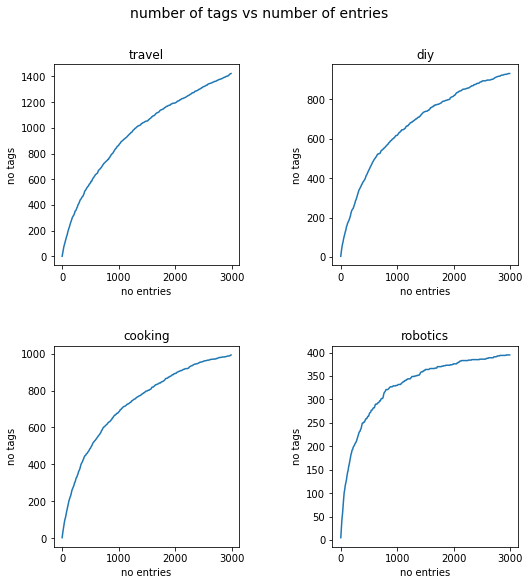

In [5]:
def find_total_tags(series,n):
    tag_set = set()
    for tags in series[:n]:
        for tag in tags.split(' '):
            tag_set.add(tag)
    return len(tag_set)
labels = ['travel','diy','robotics','cooking']
rows,columns = 2,2
f, ax = plt.subplots(rows,columns)
for m,label in enumerate(labels):
    df = pd.read_csv('./data/{}.csv'.format(label))
    x_c = range(1,len(df['tags']),10)
    y_c = map(lambda n: find_total_tags(df['tags'],n),x_c)
    i = m/columns
    j = m%columns - m/columns
    ax[i][j].plot(x_c,y_c)
    ax[i][j].set_title(label)
    ax[i][j].set_xlabel('no entries')
    ax[i][j].set_ylabel('no tags')
f.subplots_adjust(wspace=.5,hspace=.4,right = 1.2,top=1.8)
f.suptitle('number of tags vs number of entries',fontsize=14,y=2,x=.6)
plt.show()

In [6]:
cooking_data = pd.concat(df_cooking['terms'].values,ignore_index=True)
cooking_data_mean = cooking_data.groupby(['term'])[['content_tfidf','title_tfidf']].mean()
cooking_data_mean.columns=['global_content_tfidf','global_title_tfidf']
cooking_data = cooking_data.merge(cooking_data_mean,how='inner',left_on='term',right_index=True)

In [7]:
tagged_mean = cooking_data[cooking_data['tagged']]['title_tfidf'].mean()
tagged_std = cooking_data[cooking_data['tagged']]['title_tfidf'].std()
untagged_mean = cooking_data[~cooking_data['tagged']]['title_tfidf'].mean()
untagged_std = cooking_data[~cooking_data['tagged']]['title_tfidf'].std()
print 'tagged terms average title-tfidf values: %.3f+/-%.3f'%(tagged_mean,tagged_std)
print 'untagged terms average title-tfidf values: %.3f+/-%.3f'%(untagged_mean,untagged_std)

tagged terms average title-tfidf values: 0.398+/-0.207
untagged terms average title-tfidf values: 0.068+/-0.163


#### Combining the operations
Now that we have came up with a list of features we want, lets put all of these transformations in one function that can be easily applied to any of the six dataframes we are analyzing.

In [8]:
def format_dataframe(df,filter_=False):
    """Processes a raw dataframe with title, content, and pos 
    columns into a dataframe of useful features.
    
    Parameters:
    ---------------
    df: input dataframe, must have the three columns: title,content,tagged
    filter_: Boolean, whether or not to include the terms with zero content
             and title tfidf.   
    
    Returns:
    ---------------
    A pandas dataframe consisting of the following columns
    term:
    title_tfidf:
    content_tfidf:
    pos:
    word_length:
    original_index:
    """
    #create term datasets
    df['terms'] = df[['content','title']].apply(lambda x: x[0]+x[1],axis=1)\
                                                    .map(create_word_dataframe)
    #drop the index which can screw up the create_tfidf function
    df = df.reset_index(inplace=False,drop=True)
    # find tfidf values for each word in title and content
    create_tfidf(df,'content')
    create_tfidf(df,'title')
    #find the ranks of the tfidf values for each entry
    df['terms'].map(find_ranks)
    #add a row consisting of whether or not the words are present in the tags
    df[['terms','tags']].apply(lambda x: add_tags(*x),axis=1)
    #Add in the original index so we can reference this later
    def add_original_index(index,dataframe):
        dataframe['original_index']=index
    df['index'] = df.index
    df[['index','terms']].apply(lambda x: add_original_index(*x),axis=1)
    #Now that we have found the relevent data for each row, extract this
    data = pd.concat(df['terms'].values,ignore_index=True)
    #Add word lengths
    data['word_length'] = data['term'].map(lambda x:len(x))
    #Find the average tfidf of each term for title and content
    data_mean = data.groupby(['term'])[['content_tfidf','title_tfidf']].mean()
    data_mean.columns=['global_content_tfidf','global_title_tfidf']
    data = data.merge(data_mean,how='inner',left_on='term',right_index=True)
    #filter out terms with zero data and discard them
    if filter_:
        data = data[(data['title_tfidf']!=0)&(data['content_tfidf']!=0)]
    return data.sort_index()
df_robotics = pd.read_csv('./data/robotics.csv')
data = format_dataframe(df_robotics)
data.head()

,term,pos,content_tfidf,word_length,title_tfidf,content_tfidf_ranks,title_tfidf_ranks,total_terms,tagged,original_index,global_content_tfidf,global_title_tfidf
0,trying,VBG,0.136466,6,0.0,20,87,87,False,0,0.058155,0.002851
1,build,VB,0.058474,5,0.0,65,87,87,False,0,0.086654,0.049320
2,robotic,JJ,0.033934,7,0.0,75,87,87,False,0,0.091710,0.124021
3,platform,NN,0.087774,8,0.0,38,87,87,False,0,0.142413,0.055978
4,kind,NN,0.072662,4,0.0,54,87,87,False,0,0.085097,0.023851


## Exploratory Data Analysis: <a id='3'></a>

### TF-IDF <a id='3.1'></a>
At this point, we have processed each stack exchange entry into a useful set of features.  Now, lets do some exploratory data analysis to see the relationship between content tfidf, title_tfidf, and the tfidf ranks.  Since there's many more untagged points, we will limit the number of untagged points we plot to be roughly equal to the amount of tagged points 

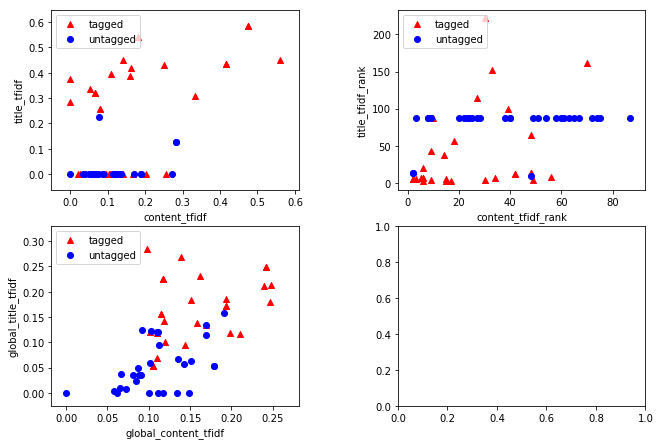

In [9]:
terms =data[:4000]
f, ax = plt.subplots(2,2)
no_tagged_terms = terms['tagged'].sum()
ax[0][0].scatter(terms[terms['tagged']]['content_tfidf'],terms[terms['tagged']]['title_tfidf'],
              c = 'r', label = 'tagged',marker='^')
ax[0][0].scatter(terms[~terms['tagged']]['content_tfidf'][:no_tagged_terms],
              terms[~terms['tagged']]['title_tfidf'][:no_tagged_terms],c='b',label='untagged')
ax[0][0].legend(loc='upper left')
ax[0][0].set_xlabel('content_tfidf')
ax[0][0].set_ylabel('title_tfidf')
# f.title('Term frequency/inverse document frequency')
ax[0][1].scatter(terms[terms['tagged']]['content_tfidf_ranks'],terms[terms['tagged']]['title_tfidf_ranks'],
              c='r',label='tagged',marker='^')
ax[0][1].scatter(terms[~terms['tagged']]['content_tfidf_ranks'][:no_tagged_terms],
              terms[~terms['tagged']]['title_tfidf_ranks'][:no_tagged_terms],c='b',label='untagged',marker='o')
ax[0][1].set_ylabel('title_tfidf_rank')
ax[0][1].set_xlabel('content_tfidf_rank')
ax[0][1].legend(loc='upper left')
ax[1][0].scatter(terms[terms['tagged']]['global_content_tfidf'],terms[terms['tagged']]['global_title_tfidf'],
              c = 'r', label = 'tagged',marker='^')
ax[1][0].scatter(terms[~terms['tagged']]['global_content_tfidf'][:no_tagged_terms],
              terms[~terms['tagged']]['global_title_tfidf'][:no_tagged_terms],c='b',label='untagged')
ax[1][0].legend(loc='upper left')
ax[1][0].set_xlabel('global_content_tfidf')
ax[1][0].set_ylabel('global_title_tfidf')
f.subplots_adjust(wspace=.4,right=1.5,top=1.5)
plt.show()

From this we see that the terms which have a title or content tfidf of zero are very unlikely to be tagged, hence we can exclude them from consideration by simply cutting them off.   

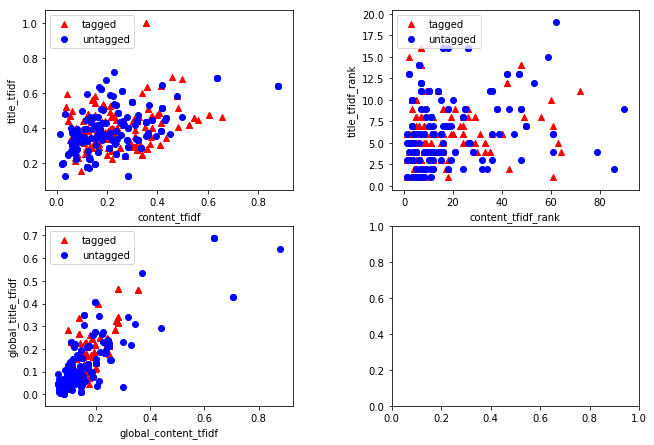

In [10]:
data_nzero = data[(data['content_tfidf']!=0)&(data['title_tfidf']!=0)]
terms =data_nzero[:4000]
f, ax = plt.subplots(2,2)
no_tagged_terms = terms['tagged'].sum()
ax[0][0].scatter(terms[terms['tagged']]['content_tfidf'],terms[terms['tagged']]['title_tfidf'],
              c = 'r', label = 'tagged',marker='^')
ax[0][0].scatter(terms[~terms['tagged']]['content_tfidf'][:no_tagged_terms],
              terms[~terms['tagged']]['title_tfidf'][:no_tagged_terms],c='b',label='untagged')
ax[0][0].legend(loc='upper left')
ax[0][0].set_xlabel('content_tfidf')
ax[0][0].set_ylabel('title_tfidf')
# f.title('Term frequency/inverse document frequency')
ax[0][1].scatter(terms[terms['tagged']]['content_tfidf_ranks'],terms[terms['tagged']]['title_tfidf_ranks'],
              c='r',label='tagged',marker='^')
ax[0][1].scatter(terms[~terms['tagged']]['content_tfidf_ranks'][:no_tagged_terms],
              terms[~terms['tagged']]['title_tfidf_ranks'][:no_tagged_terms],c='b',label='untagged',marker='o')
ax[0][1].set_ylabel('title_tfidf_rank')
ax[0][1].set_xlabel('content_tfidf_rank')
ax[0][1].legend(loc='upper left')
ax[1][0].scatter(terms[terms['tagged']]['global_content_tfidf'],terms[terms['tagged']]['global_title_tfidf'],
              c = 'r', label = 'tagged',marker='^')
ax[1][0].scatter(terms[~terms['tagged']]['global_content_tfidf'][:no_tagged_terms],
              terms[~terms['tagged']]['global_title_tfidf'][:no_tagged_terms],c='b',label='untagged')
ax[1][0].legend(loc='upper left')
ax[1][0].set_xlabel('global_content_tfidf')
ax[1][0].set_ylabel('global_title_tfidf')
f.subplots_adjust(wspace=.4,right=1.5,top=1.5)
plt.show()

### Word length <a id='3.2'></a>

We might find that the word length is also somewhat predictive of a word being tagged or not.  The longer a word is, the higher probability it has of being tagged.   We can see for all of the words, the probability that a word is tagged tends to increase with length, with the exception of words with three letters which tend to be acronyms and are slightly more likely to be tagged.

C:\Users\Michael\Anaconda3\envs\python_27\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


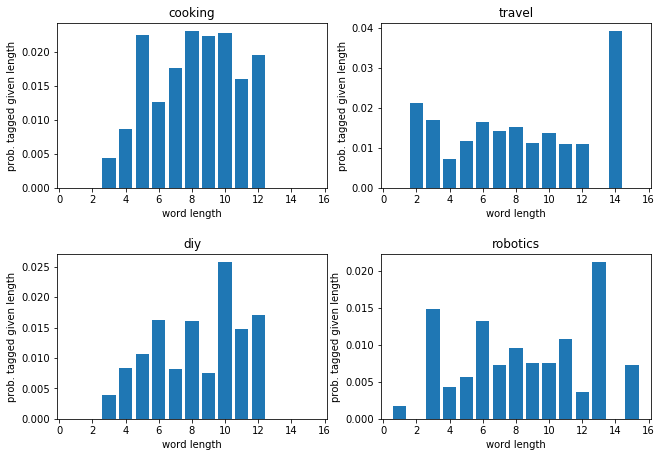

In [11]:
fig,ax = plt.subplots(2,2)
for n,tag in enumerate(['cooking','travel','diy','robotics']):
    df = pd.read_csv('./data/{}.csv'.format(tag))
    data = format_dataframe(df.head(500))
    word_lengths = np.unique(data['word_length'].values)
    no_tagged = data.groupby('word_length').tagged.sum()
    no_total = data.groupby('word_length').tagged.count()
    column = n%2
    row = n/2
    ax[row][column].bar(word_lengths[:15],(no_tagged/no_total)[:15])
    ax[row][column].set_title(tag)
    ax[row][column].set_xlabel('word length')
    ax[row][column].set_ylabel('prob. tagged given length')
fig.subplots_adjust(top = 1.5,right=1.5,hspace=.4)
plt.show()

At this point we will need to analyze more then one formatted dataframe, so we will create and save these now.   

In [12]:
for term in ['cooking','travel','robotics','diy']:
    df = pd.read_csv('./data/{}.csv'.format(term))
    data = format_dataframe(df)
    data.to_csv('./data/data_{}.csv'.format(term),encoding='utf-8',index=False)

#### Part of Speech <a id='3.3'></a>

There are several parts of speech, however we can see that if a word is tagged NN, then it is much more likely to be a tagged word.   The next most likely categories are NNS, JJ, VB, and VBG.   

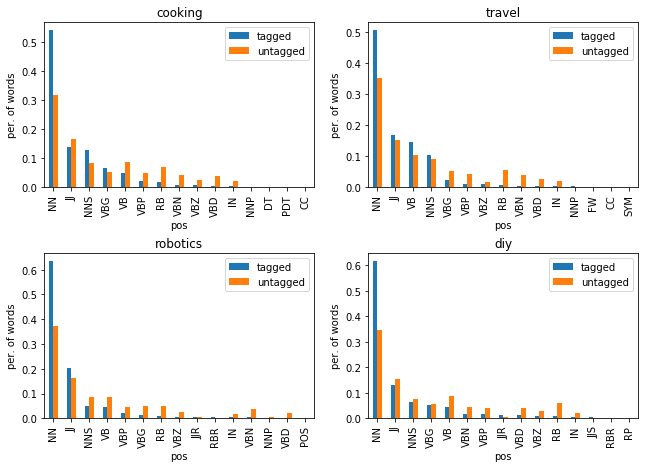

In [13]:
fig,axis = plt.subplots(2,2)
for ix,term in enumerate(['cooking','travel','robotics','diy']):
    data = pd.read_csv('./data/data_{}.csv'.format(term))
    tagged_pos = data[data['tagged']].groupby('pos')['tagged'].count()
    tagged_pos = 1.*tagged_pos/tagged_pos.sum()
    untagged_pos = data[~data.tagged].groupby('pos')['tagged'].count()
    untagged_pos = 1.*untagged_pos/untagged_pos.sum()
    a = pd.DataFrame([tagged_pos,untagged_pos]).transpose()
    a.columns=['tagged','untagged']
    a.fillna(0,inplace=True)
    a.sort_values('tagged',inplace=True,ascending=False)
    row = ix/2
    column = ix%2
    a[:15].plot(kind='bar',ax=axis[row][column])
    axis[row][column].set_xlabel('pos')
    axis[row][column].set_ylabel('per. of words')
    axis[row][column].set_title(term)
fig.subplots_adjust(top=1.5,right=1.5,hspace=.4)
plt.show()

This suggests to us that we should use the part of speech as a predictive measure.  To show this more clearly, lets look at the probability that a word will be tagged given that it is a noun, a verb, etc.   Of course if a part of speech only occurs one time, then it won't be useful to pay attention to its probability, so lets make the cutoff that the type of word has to occur more then 1% of the time.  

The graphs illustrate that across all subjects, NN and NNS labled words are the most likely to be tagged.   

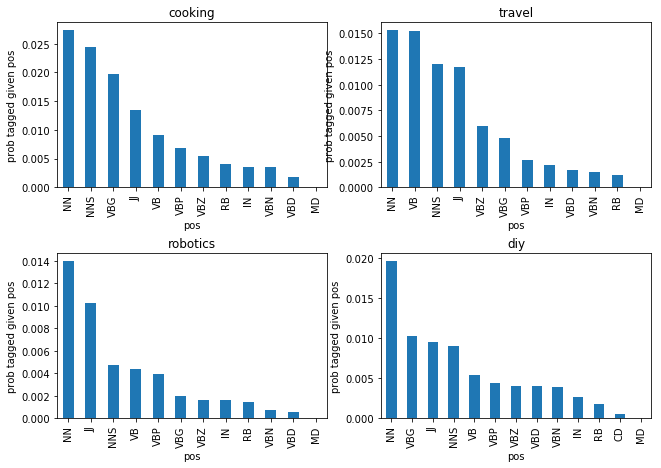

In [14]:
fig,axis = plt.subplots(2,2)
for ix,term in enumerate(['cooking','travel','robotics','diy']):
    data = pd.read_csv('./data/data_{}.csv'.format(term))
    data_grouped = data.groupby('pos')['tagged']
    grt = (1.*data_grouped.count())/(data_grouped.count().sum())>.01
    prob_tagged_pos = data_grouped.mean()[grt].sort_values(ascending=False)
    row = ix/2
    column = ix%2
    prob_tagged_pos[:15].plot(kind='bar',ax=axis[row][column])
    axis[row][column].set_xlabel('pos')
    axis[row][column].set_ylabel('prob tagged given pos')
    axis[row][column].set_title(term)
fig.subplots_adjust(top=1.5,right=1.5,hspace=.4)
plt.show()

## Building the model <a id='4'></a>

Now that we have came up with a useful list of features, its time to build a model.  The end goal is not only to be able to train and predict tags within one dataset, but it is instead to be able to train the model on one dataset, such as cooking stack exchange questions, and then use it to predict tags from physics stack exchange questions.

Because this is a complicated task, I will first construct some models for predicting the tags within a specific dataset, then apply these models across datasets.   

#### SVM classifiers <a id='4.1'></a>

A support vector machine attempts to classify data by creating a hyperplane which seperates both classes.   The hyperplane is chosen so that as many points as possible lie in the right side, and that there is a large margin around the hyperplane where the points aren't close.   Although the first SVM was linear, SVM's can be used as non-linear classifiers by first mapping the data to a higher dimensional space where it can be linearly seperated, and then creating a hyperplane which lies between them.  This turns out not to be as computational expensive via the kernel trick.   

Since we saw before that our data wasn't linearly seperable, we can use the non-linear kernels.   Also since most of the words are not-tagged, we wan't to weight the points which are tagged more heavily (since the model will tend towards predicting that nothing is tagged which has a 95% accuracy).   

We will also need to deal with the word types.   Fortunately, we can see that the amount of word types used in tags is relatively small, and we could seperate these out into seperate features to use with one hot encoding.  However, if we do this, then the model is unlikely to be able to predict tags in different subjects since the word type distibution for tagged words varies between tags.  Instead, I will seperate the words out into three categories, one for words labeled NN, one for JJ,NNS,VB,VBP, VBG, VBN, VBZ, or VBD, and one for all other tags.   

In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
data = pd.read_csv('./data/data_travel.csv')
data['pos'] = data['pos'].map(lambda x: 1 if x=='NN' else 2 if x in {'JJ','NNS','VB',\
                                                 'VBP','VBG','VBN','VB','VBD'} else 0)

svm = SVC()
course_params = {'kernel':['rbf'],'C':[2**x for x in range(-5,16,2)],'gamma':[2**x for x in range(-15,4,2)],
                 'class_weight':['balanced']}
data[data.columns.difference({'term','tagged','total_terms','original_index'})].values[:5,4]
ohe = OneHotEncoder(categorical_features=[4])
X = ohe.fit_transform(data[data.columns.difference({'term','tagged','total_terms','original_index'})].values[:2000,:])
y = data.tagged[:2000]
ss = StandardScaler()
X = ss.fit_transform(X.toarray())
gs = GridSearchCV(svm,course_params,scoring='f1',n_jobs=-1,cv=5)
gs.fit(X,y)
print gs.best_params_
print gs.best_score_
fine_parameters = {'kernel':['rbf'],'C':[gs.best_params_['C']*(2**x) for x in np.arange(-1.5,1.75,.25)],
                   'gamma':[gs.best_params_['gamma']*(2**x) for x in np.arange(-1.5,1.75,.25)],
                   'class_weight':['balanced']}
gs = GridSearchCV(svm,fine_parameters,scoring='f1',n_jobs=-1,cv=5)
gs.fit(X,y)
print gs.best_score_
gs.best_params_

{'kernel': 'rbf', 'C': 0.03125, 'gamma': 0.001953125, 'class_weight': 'balanced'}
0.267702226851
0.308869351484


{'C': 0.03125,
 'class_weight': 'balanced',
 'gamma': 0.0009765625,
 'kernel': 'rbf'}

We can try this on several datasets, and apply the classifiers from each dataset to the other datasets

cooking
0.269825084997
{'kernel': 'rbf', 'C': 0.25, 'gamma': 3.0517578125e-05, 'class_weight': 'balanced'}
travel
0.211490400852
{'kernel': 'rbf', 'C': 0.21022410381342863, 'gamma': 4.3158372875155492e-05, 'class_weight': 'balanced'}
robotics
0.147882574397
{'kernel': 'rbf', 'C': 0.011048543456039806, 'gamma': 0.0009765625, 'class_weight': 'balanced'}
diy
0.155455023092
{'kernel': 'rbf', 'C': 0.21022410381342863, 'gamma': 4.3158372875155492e-05, 'class_weight': 'balanced'}
f1 scores for estimators trained on each of the four datasets (rows), tested on each of the four datasets (columns)


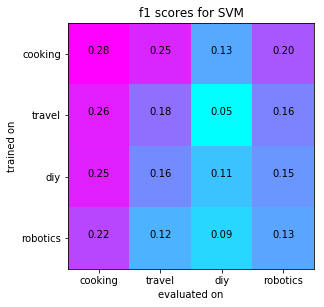

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import itertools
results = []
svm_estimators = []
test_X=[]
test_y=[]
ohe = OneHotEncoder(categorical_features=[4])
course_params = {'kernel':['rbf'],'C':[2**x for x in range(-5,16,2)],'gamma':[2**x for x in range(-15,4,2)],
                 'class_weight':['balanced']}
for subject in ['cooking','travel','robotics','diy']:
    data = pd.read_csv('./data/data_{}.csv'.format(subject))
    data['pos'] = data['pos'].map(lambda x: 1 if x=='NN' else 2 if x in {'JJ','NNS','VB',\
                                                 'VBP','VBG','VBN','VB','VBD'} else 0)
    X = ohe.fit_transform(data[data.columns.difference({'term','tagged','total_terms','original_index'})].values)
    y = data.tagged
    ss = StandardScaler()
    X = ss.fit_transform(X.toarray())
    X_train,X_test,y_train,y_test = train_test_split(X,y)
    gs = GridSearchCV(svm,course_params,scoring='f1',n_jobs=-1,cv=5)
    gs.fit(X_train[:5000],y_train[:5000])
    fine_parameters = {'kernel':['rbf'],'C':[gs.best_params_['C']*(2**x) for x in np.arange(-1.5,1.75,.25)],
                   'gamma':[gs.best_params_['gamma']*(2**x) for x in np.arange(-1.5,1.75,.25)],
                   'class_weight':['balanced']}
    gs = GridSearchCV(svm,fine_parameters,scoring='f1',n_jobs=-1,cv=5)
    gs.fit(X_train[:5000],y_train[:5000])
    svm_estimators.append(gs.best_estimator_)
    print subject
    print gs.best_score_
    print gs.best_params_
    test_X.append(X_test[:5000]) 
    test_y.append(y_test[:5000])
print "f1 scores for estimators trained on each of the four datasets (rows), tested on each of the four datasets (columns)"
matrix = np.array([[f1_score(y,est.predict(X)) for X,y in zip(test_X,test_y)] for est in svm_estimators])
classes = ['cooking','travel','robotics','diy']
plt.imshow(matrix,interpolation='nearest',cmap=plt.cm.cool)
tick_marks = np.arange(4)
plt.xticks(tick_marks,classes)
plt.yticks(tick_marks,classes)
for i,j in itertools.product(range(4),range(4)):
    plt.text(j,i,'{:.2f}'.format(matrix[i,j]),horizontalalignment='center',color='black')
plt.tight_layout()
plt.ylabel('trained on')
plt.xlabel('evaluated on')
plt.title('f1 scores for SVM')
plt.show()

This works, however we might be interested in seeing if bagging can improve the results.  Bagging involves training different classifiers on subsets of the data.   The final prediction is then done by a majority vote by all of the classifiers.   We will also try restricting the number of features as a parameter in our grid search.  Finally, to speed up the calculation, we will pick the best values of C and gamma from our last search as our values of C and gamma. 

cooking
0.224497519506
{'max_features': 0.6}
travel
0.120789121128
{'max_features': 0.8}
robotics
0.0960779990447
{'max_features': 0.6}
diy
0.12809828416
{'max_features': 0.8}
f1 scores for estimators trained on each of the four datasets (rows), tested on each of the four datasets (columns)


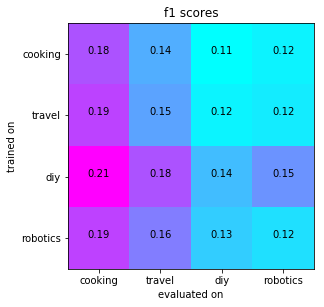

In [17]:
from sklearn.ensemble import BaggingClassifier
svm = SVC(C=0.044194173824159223,gamma=0.044194173824159223,kernel='rbf',class_weight='balanced')
bc = BaggingClassifier(svm,n_estimators=10,max_samples = 1000)
results = []
bagging_estimators = []
test_X = []
test_y = []
ohe = OneHotEncoder(categorical_features=[4])
params = {'max_features':[.4,.6,.8]}
for subject in ['cooking','travel','robotics','diy']:
    data = pd.read_csv('./data/data_{}.csv'.format(subject))
    data['pos'] = data['pos'].map(lambda x: 1 if x=='NN' else 2 if x in {'JJ','NNS','VB',\
                                                 'VBP','VBG','VBN','VB','VBD'} else 0)
    X = ohe.fit_transform(data[data.columns.difference({'term','tagged','total_terms','original_index'})].values)
    y = data.tagged
    ss = StandardScaler()
    X = ss.fit_transform(X.toarray())
    X_train,X_test,y_train,y_test = train_test_split(X,y)
    gs = GridSearchCV(bc,params,scoring='f1',n_jobs=-1,cv=5)
    gs.fit(X_train[:5000],y_train[:5000])
    bagging_estimators.append(gs.best_estimator_)
    print subject
    print gs.best_score_
    print gs.best_params_
    test_X.append(X_test[:5000]) 
    test_y.append(y_test[:5000])
print "f1 scores for estimators trained on each of the four datasets (rows), tested on each of the four datasets (columns)"
matrix = np.array([[f1_score(y,est.predict(X)) for X,y in zip(test_X,test_y)] for est in bagging_estimators])
classes = ['cooking','travel','robotics','diy']
plt.imshow(matrix,interpolation='nearest',cmap=plt.cm.cool)
tick_marks = np.arange(4)
plt.xticks(tick_marks,classes)
plt.yticks(tick_marks,classes)
for i,j in itertools.product(range(4),range(4)):
    plt.text(j,i,'{:.2f}'.format(matrix[i,j]),horizontalalignment='center',color='black')
plt.tight_layout()
plt.ylabel('trained on')
plt.xlabel('evaluated on')
plt.title('f1 scores')
plt.show()

We can see that this doesn't provide that much benifit in accurate scores, however, timewise, this method ends up being much faster then the previous methods.  

### Stochastic Gradient descent with kernel approximation <a id='4.2'></a>

The previous method gave good results, however, we might wan't to train our classifier using all of the dataset.  To do this, we need to use stochastic gradient descent.  Although this is usually used for fitting linear methods, we can use a the sklearn kernel approximator to map the data into a higher dimensional space before feeding it into our classifier.   The mapping tries to approximate the mapping of the rbf kernel.   

cooking
0.254782126931
{'clf__class_weight': 'balanced', 'rbf__gamma': 0.0032847516220848223, 'clf__alpha': 0.022097086912079612}
travel
0.164847047504
{'clf__class_weight': 'balanced', 'rbf__gamma': 0.00069053396600248786, 'clf__alpha': 7.2583442077802797e-05}
robotics
0.174772685536
{'clf__class_weight': 'balanced', 'rbf__gamma': 0.00069053396600248786, 'clf__alpha': 0.00034526698300124393}
diy
0.197326007326
{'clf__class_weight': 'balanced', 'rbf__gamma': 0.0011613350732448448, 'clf__alpha': 0.00058066753662242238}
f1 scores for estimators trained on each of the four datasets (rows), tested on each of the four datasets (columns)


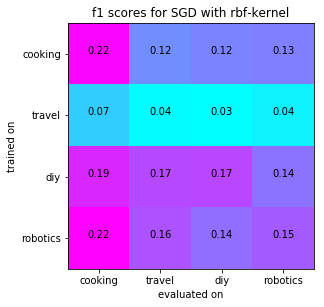

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
rbf_feature = RBFSampler()
clf = SGDClassifier()
results = []
sgd_estimators = []
test_X = []
test_y = []
pipe = Pipeline([('rbf',RBFSampler()),('clf',SGDClassifier())])
param_grid = {'rbf__gamma':[2**x for x in range(-15,4,2)],'clf__alpha':[2**x for x in range(-16,5,2)],
             'clf__class_weight':['balanced']}
for subject in ['cooking','travel','robotics','diy']:
    data = pd.read_csv('./data/data_{}.csv'.format(subject))
    data['pos'] = data['pos'].map(lambda x: 1 if x=='NN' else 2 if x in {'JJ','NNS','VB',\
                                                 'VBP','VBG','VBN','VB','VBD'} else 0)
    X = ohe.fit_transform(data[data.columns.difference({'term','tagged','total_terms','original_index'})].values)
    y = data.tagged
    ss = StandardScaler()
    X = ss.fit_transform(X.toarray())
    X_train,X_test,y_train,y_test = train_test_split(X,y)
    gs = GridSearchCV(pipe,param_grid,scoring='f1',n_jobs=-1,cv=5)
    gs.fit(X_train[:5000],y_train[:5000])
    fine_parameters = {'clf__alpha':[gs.best_params_['clf__alpha']*(2**x) for x in np.arange(-1.5,1.75,.25)],
                    'rbf__gamma':[gs.best_params_['rbf__gamma']*(2**x) for x in np.arange(-1.5,1.75,.25)],
                    'clf__class_weight':['balanced']}
    gs = GridSearchCV(pipe,fine_parameters,scoring='f1',n_jobs=-1,cv=5)
    gs.fit(X_train[:5000],y_train[:5000])
    test_X.append(X_test[:5000]) 
    test_y.append(y_test[:5000])
    print subject
    print gs.best_score_
    print gs.best_params_
    sgd_estimators.append(gs.best_estimator_)
print "f1 scores for estimators trained on each of the four datasets (rows), tested on each of the four datasets (columns)"
matrix = np.array([[f1_score(y,est.predict(X)) for X,y in zip(test_X,test_y)] for est in sgd_estimators])
classes = ['cooking','travel','robotics','diy']
plt.imshow(matrix,interpolation='nearest',cmap=plt.cm.cool)
tick_marks = np.arange(4)
plt.xticks(tick_marks,classes)
plt.yticks(tick_marks,classes)
for i,j in itertools.product(range(4),range(4)):
    plt.text(j,i,'{:.2f}'.format(matrix[i,j]),horizontalalignment='center',color='black')
plt.tight_layout()
plt.ylabel('trained on')
plt.xlabel('evaluated on')
plt.title('f1 scores for SGD with rbf-kernel')
plt.show()

We can see that although thsi runs much faster then the SVM, it does not preform nearly as well.  

### Random Forest Classifier <a id='4.3'></a>

Another good classifier to fit would be the random forest classifier.   These tend to be computationally fast, and can easily fit non-linear problems.   

cooking
0.261210199718
{'max_features': 0.8, 'n_estimators': 100, 'min_samples_leaf': 10, 'class_weight': 'balanced'}
travel
0.25853514661
{'max_features': 0.4, 'n_estimators': 100, 'min_samples_leaf': 10, 'class_weight': 'balanced'}
robotics
0.18737478029
{'max_features': 0.2, 'n_estimators': 100, 'min_samples_leaf': 15, 'class_weight': 'balanced'}
diy
0.24502314213
{'max_features': 0.2, 'n_estimators': 100, 'min_samples_leaf': 5, 'class_weight': 'balanced'}
f1 scores for estimators trained on each of the four datasets (rows), tested on each of the four datasets (columns)


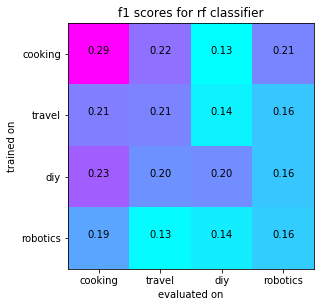

In [22]:
from sklearn.ensemble import RandomForestClassifier
results = []
rf_estimators = []
test_X = []
test_y = []
rf = RandomForestClassifier()
params = {'class_weight':['balanced'],'n_estimators':[100],'min_samples_leaf':[1,5,10,15,20],
         'max_features':[.2,.4,.6,.8]}
rf.get_params()
for subject in ['cooking','travel','robotics','diy']:
    data = pd.read_csv('./data/data_{}.csv'.format(subject))
    data['pos'] = data['pos'].map(lambda x: 1 if x=='NN' else 2 if x in {'JJ','NNS','VB',\
                                                 'VBP','VBG','VBN','VB','VBD'} else 0)
    X = data[data.columns.difference({'term','tagged','total_terms','original_index'})].values
    y = data.tagged
    X_train,X_test,y_train,y_test = train_test_split(X,y)
    gs = GridSearchCV(rf,params,scoring='f1',n_jobs=-1,cv=5)
    gs.fit(X_train[:10000],y_train[:10000])
    rf_estimators.append(gs.best_estimator_)
    print subject
    print gs.best_score_
    print gs.best_params_
    test_X.append(X_test[:10000]) 
    test_y.append(y_test[:10000])
print "f1 scores for estimators trained on each of the four datasets (rows), tested on each of the four datasets (columns)"
matrix = np.array([[f1_score(y,est.predict(X)) for X,y in zip(test_X,test_y)] for est in rf_estimators])
classes = ['cooking','travel','robotics','diy']
plt.imshow(matrix,interpolation='nearest',cmap=plt.cm.cool)
tick_marks = np.arange(4)
plt.xticks(tick_marks,classes)
plt.yticks(tick_marks,classes)
for i,j in itertools.product(range(4),range(4)):
    plt.text(j,i,'{:.2f}'.format(matrix[i,j]),horizontalalignment='center',color='black')
plt.tight_layout()
plt.ylabel('trained on')
plt.xlabel('evaluated on')
plt.title('f1 scores for rf classifier')
plt.show()

As we can see, random forest classifiers perform as well as the SVM classifier, however it takes a fraction of the time to train a random forest classifier as it does an SVM classifier.   We might be interested in increasing the number of estimators in the random forest which almost always makes a model more predictive at the cost of extra computational time.   

cooking
0.309566575745
{'max_features': 0.6, 'n_estimators': 200, 'min_samples_leaf': 10, 'class_weight': 'balanced'}
travel
0.199249098018
{'max_features': 0.6, 'n_estimators': 200, 'min_samples_leaf': 20, 'class_weight': 'balanced'}
robotics
0.218664619214
{'max_features': 0.6, 'n_estimators': 200, 'min_samples_leaf': 10, 'class_weight': 'balanced'}
diy
0.186510988709
{'max_features': 0.4, 'n_estimators': 200, 'min_samples_leaf': 10, 'class_weight': 'balanced'}
f1 scores for estimators trained on each of the four datasets (rows), tested on each of the four datasets (columns)


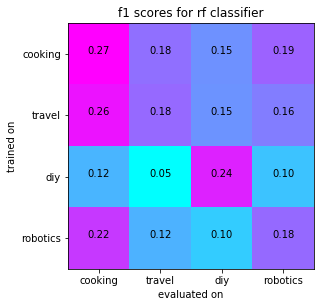

In [24]:
from sklearn.ensemble import RandomForestClassifier
results = []
rf_estimators = []
test_X = []
test_y = []
rf = RandomForestClassifier()
params = {'class_weight':['balanced'],'n_estimators':[200],'min_samples_leaf':[1,5,10,15,20],
         'max_features':[.2,.4,.6,.8]}
rf.get_params()
for subject in ['cooking','travel','robotics','diy']:
    data = pd.read_csv('./data/data_{}.csv'.format(subject))
    data['pos'] = data['pos'].map(lambda x: 1 if x=='NN' else 2 if x in {'JJ','NNS','VB',\
                                                 'VBP','VBG','VBN','VB','VBD'} else 0)
    X = data[data.columns.difference({'term','tagged','total_terms','original_index'})].values
    y = data.tagged
    X_train,X_test,y_train,y_test = train_test_split(X,y)
    gs = GridSearchCV(rf,params,scoring='f1',n_jobs=-1,cv=5)
    gs.fit(X_train[:10000],y_train[:10000])
    rf_estimators.append(gs.best_estimator_)
    print subject
    print gs.best_score_
    print gs.best_params_
    test_X.append(X_test[:10000]) 
    test_y.append(y_test[:10000])
print "f1 scores for estimators trained on each of the four datasets (rows), tested on each of the four datasets (columns)"
matrix = np.array([[f1_score(y,est.predict(X)) for X,y in zip(test_X,test_y)] for est in rf_estimators])
classes = ['cooking','travel','robotics','diy']
plt.imshow(matrix,interpolation='nearest',cmap=plt.cm.cool)
tick_marks = np.arange(4)
plt.xticks(tick_marks,classes)
plt.yticks(tick_marks,classes)
for i,j in itertools.product(range(4),range(4)):
    plt.text(j,i,'{:.2f}'.format(matrix[i,j]),horizontalalignment='center',color='black')
plt.tight_layout()
plt.ylabel('trained on')
plt.xlabel('evaluated on')
plt.title('f1 scores for rf classifier')
plt.show()

## Testing the model <a id='5'></a>

We can see that the highest scores are achieved by using a random foest classifier, however, when applying this model to unseen datasets, its not obvious which model should be used to predict.  Rather then choosing one classifier to predict the data, we will use all of the classifiers.  There are two ways we can do this, a soft classification, which uses each estimator to find the probabilities of either class membership, and then choosing the highest probability, or we can use a majority voting scheme, where each classifier votes for the label to be either 0 or 1 and the category with the most votes wins.   

To test these out, I will download and process four more dataframes and test the models on these datsets.   

In [55]:
class EnsembleVote(object):
    """ Takes a collection of fitted binary classifiers, and
    yields predictions based on the votes of the classifiers.
    The types of prediction offered are:
    soft: yeilds predictions based off the classifier with 
          the highest probabilty.
    hard: yields predictions based of simple majority vote of 
          all classifiers
          
    Parameters:
    -------------
    estimators: an iterable collection of estimators, each of which 
                must be fitted prior to adding in, and each of which
                must have the method predict if type_==hard, or 
                predict_proba if type_==soft.
    type_:      String, options are soft or hard.
    
    Attributes:
    -------------
    estimators: list of classifiers
    type_: String, type of classification
    """
    def __init__(self,estimators,type_='hard'):
        self.estimators=estimators
        if not type in {'hard','soft'}:
            raise Exception('Illegal argument')
    def predict_soft(self,X):
        results = np.hstack([est.predict_proba(X) for est in rf_estimators])
        predictions = np.argmax(results,axis=1)%2==1
        return predictions.astype(int)
    def predict_hard(self,X):
        results = np.hstack([est.predict(X)]).mean(axis=1)>=.5
        return results.astype(int)
    def predict(self,X):
        """Given an input, finds the predictions of the classifiers,
        Parameters:
        -------------
        X: array-like, shape = n_samples,n_features
        
        Returns:
        -------------
        array of predictions.   
        """
        if type=='hard':
            return predict_hard(X)
        else:
            return predict_soft(X)
labels = ['cooking','travel','robotics','diy']
vc_rf = WeightedVote(rf_estimators)
vc_svm = WeightedVote(svm_estimators)
data_music = format_dataframe(construct_dataframe('music',1000))
data_fitness = format_dataframe(construct_dataframe('fitness',1000))
data_music['pos'] = data_music['pos'].map(lambda x: 1 if x=='NN' else 2 if x in {'JJ','NNS','VB',\
                                                 'VBP','VBG','VBN','VB','VBD'} else 0)
X_music = data_music[data_music.columns.difference({'term','tagged','total_terms','original_index'})].values
y_music = data_music.tagged
data_fitness['pos'] = data_fitness['pos'].map(lambda x: 1 if x=='NN' else 2 if x in {'JJ','NNS','VB',\
                                                 'VBP','VBG','VBN','VB','VBD'} else 0)
X_fitness = data_fitness[data_fitness.columns.difference({'term','tagged','total_terms','original_index'})].values
y_fitness = data_fitness.tagged
f1_music_rf = f1_score(vc_rf.predict(X_music),y_music)
f1_music_svm = f1_score(vc_svm.predict(X_music),y_music)
f1_fitness_rf = f1_score(vc_rf.predict(X_fitness),y_fitness)
f1_fitness_svm = f1_score(vc_svm.predict(X_fitness),y_fitness)

matrix = np.array([[f1_music_rf,f1_fitness_rf],[f1_music_svm,f1_fitness_svm]])
y_labels = ['SVM','RF']
x_labels = ['music','fitness']
plt.imshow(matrix,interpolation='nearest',cmap=plt.cm.cool)
tick_marks = np.arange(4)
plt.xticks(tick_marks,x_labels)
plt.yticks(tick_marks,y_labels)
for i,j in itertools.product(range(2),range(2)):
    plt.text(j,i,'{:.2f}'.format(matrix[i,j]),horizontalalignment='center',color='black')
plt.tight_layout()
plt.ylabel('Classifier')
plt.xlabel('test dataset')
plt.title('f1 scores for unseen datasets')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [10, 45135]

In [56]:
X_music = data_music[data_music.columns.difference({'term','tagged','total_terms','original_index'})].values
y_music = data_music.tagged
X_fitness = data_fitness[data_fitness.columns.difference({'term','tagged','total_terms','original_index'})].values
y_fitness = data_fitness.tagged
class WeightedVote(object):
    def __init__(self,estimators):
        self.estimators=estimators
    def predict(self,X):
        results = np.hstack([est.predict_proba(X) for est in self.estimators])
        predictions = np.argmax(results,axis=1)%2==1
        return predictions.astype(int)
vc_rf = WeightedVote(rf_estimators)
vc_svm = WeightedVote(svm_estimators)
f1_music_rf = f1_score(vc_rf.predict(X_music),y_music)
#f1_music_svm = f1_score(vc_svm.predict(X_music),y_music)
f1_fitness_rf = f1_score(vc_rf.predict(X_fitness),y_fitness)
#f1_fitness_svm = f1_score(vc_svm.predict(X_fitness),y_fitness)
print f1_music_rf,f1_fitness_rf

matrix = np.array([[f1_music_rf,f1_fitness_rf],[f1_music_svm,f1_fitness_svm]])
y_labels = ['SVM','RF']
x_labels = ['music','fitness']
plt.imshow(matrix,interpolation='nearest',cmap=plt.cm.cool)
tick_marks = np.arange(4)
plt.xticks(tick_marks,x_labels)
plt.yticks(tick_marks,y_labels)
for i,j in itertools.product(range(2),range(2)):
    plt.text(j,i,'{:.2f}'.format(matrix[i,j]),horizontalalignment='center',color='black')
plt.tight_layout()
plt.ylabel('Classifier')
plt.xlabel('test dataset')
plt.title('f1 scores for unseen datasets')
plt.show()

0.107899807322 0.110531803962


NameError: name 'f1_music_svm' is not defined

In [59]:
for est in rf_estimators:
    f1_music_rf = f1_score(est.predict(X_music),y_music)
    #f1_music_svm = f1_score(vc_svm.predict(X_music),y_music)
    f1_fitness_rf = f1_score(est.predict(X_fitness),y_fitness)
    #f1_fitness_svm = f1_score(vc_svm.predict(X_fitness),y_fitness)
    print f1_music_rf,f1_fitness_rf

0.126450116009 0.17704011065
0.123264476803 0.177962577963
0.0660194174757 0.0725075528701
0.123867069486 0.153469387755


In [48]:
results

array([[ 1.        ,  0.        ,  0.99236348,  0.00763652,  0.70357773,
         0.29642227,  0.99134041,  0.00865959],
       [ 1.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  1.        ,  0.        ],
       [ 0.99619301,  0.00380699,  1.        ,  0.        ,  0.99087125,
         0.00912875,  1.        ,  0.        ],
       [ 1.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  1.        ,  0.        ],
       [ 1.        ,  0.        ,  0.9964798 ,  0.0035202 ,  0.95907436,
         0.04092564,  1.        ,  0.        ],
       [ 0.69817877,  0.30182123,  0.70548367,  0.29451633,  0.58741424,
         0.41258576,  0.61394106,  0.38605894],
       [ 0.30889653,  0.69110347,  0.13285425,  0.86714575,  0.43169325,
         0.56830675,  0.25853242,  0.74146758],
       [ 1.        ,  0.        ,  1.        ,  0.        ,  0.98641768,
         0.01358232,  1.        ,  0.        ],
       [ 0.90885885,  0.09114115